# Download Dataset

Download (10GB) the Military Aircraft Detection Dataset from Kaggle, unzip just the dataset into raw

Total RAW data = 8GB

**IMPORTANT**: Api key (json) from Kaggle needs to be added to the notebooks folder of the project in order to download the dataset

In [1]:
# Check if in a Google Colab
COLAB = False

try:
    import google.colab
    COLAB = True
except ImportError:
    COLAB = False

if COLAB:
    !git clone https://github.com/marcgj/sky-defender.git
    %cd sky-defender/notebooks/

Cloning into 'sky-defender'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 164 (delta 84), reused 79 (delta 24), pack-reused 0
Receiving objects: 100% (164/164), 19.63 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content/sky-defender/notebooks


In [2]:
Kaggle_ready = input('ACCEPT: ')

ACCEPT: 


#### Install Kaggle

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls


kaggle.json  SkyDefender.ipynb	sky-defender-OLD.ipynb	yolo_files


#### Download Dataset

In [5]:

TRUE_CONDITIONS = ['y', 'yes']

# Download the dataset
download = input('\tYes(Y)/No(N): ')

if download.lower() in TRUE_CONDITIONS:
    ! mkdir download
    ! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset -p download
    # Unzip the dataset
    !mkdir -p ../data/raw
    !mkdir -p ../data/interim
    !unzip -j ./download/militaryaircraftdetectiondataset.zip "dataset/*" -d ../data/raw
    # Remove temporal files?
    !rm -rf ./download

Streaming output truncated to the last 5000 lines.
  inflating: ../data/raw/c950188dfe4923b2d577425af22f0ab4.csv  
  inflating: ../data/raw/c950188dfe4923b2d577425af22f0ab4.jpg  
  inflating: ../data/raw/c9522e2db789ef9e640b32025e6f1389.csv  
  inflating: ../data/raw/c9522e2db789ef9e640b32025e6f1389.jpg  
  inflating: ../data/raw/c952684a0c721787182e00041e458100.csv  
  inflating: ../data/raw/c952684a0c721787182e00041e458100.jpg  
  inflating: ../data/raw/c95906fce406041e187591561d7f7863.csv  
  inflating: ../data/raw/c95906fce406041e187591561d7f7863.jpg  
  inflating: ../data/raw/c95b39d7565c26b9f8aedb4e77a2dd23.csv  
  inflating: ../data/raw/c95b39d7565c26b9f8aedb4e77a2dd23.jpg  
  inflating: ../data/raw/c95b4fd51b689de2f0d7b161b11b7c9e.csv  
  inflating: ../data/raw/c95b4fd51b689de2f0d7b161b11b7c9e.jpg  
  inflating: ../data/raw/c95e6f21060648f3193a7a717ba235e4.csv  
  inflating: ../data/raw/c95e6f21060648f3193a7a717ba235e4.jpg  
  inflating: ../data/raw/c95eb2b69c5a6e676120879fe72e

## Loading Dataset

In [6]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [7]:
!pwd

/content/sky-defender/notebooks


In [8]:
csv_path = "../data/raw/"
df = pd.concat([pd.read_csv(csv_path + f, delimiter=',') for f in os.listdir(csv_path) if f.endswith('.csv')], ignore_index=True)

In [9]:
df.to_csv('../data/interim/merged_info.csv', index=False)

## Checking Null Values

In [10]:
if df.isnull().values.any():
    print("There are null values in DF")
else:
    print("No null values in DF.")

No null values in DF.


## Examining classes

<Axes: ylabel='class'>

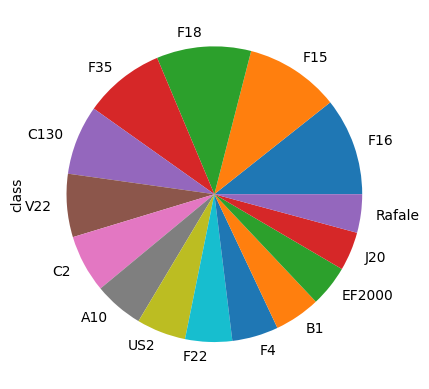

In [11]:
df["class"].value_counts().head(15).plot(kind="pie") #See where can we reduce a bit our dataset

## Reducing classes
Because the dataset is very large and our project is focused more in object detection, we will be using just 3 classes in order to reduce computing time.
This action will also reduce the difference between classes (same probability for all) and that will make our model more accurate.

Reduced from 18524 rows to 3257 rows
F16    1109
F15    1074
F18    1074
Name: class, dtype: int64


<Axes: ylabel='class'>

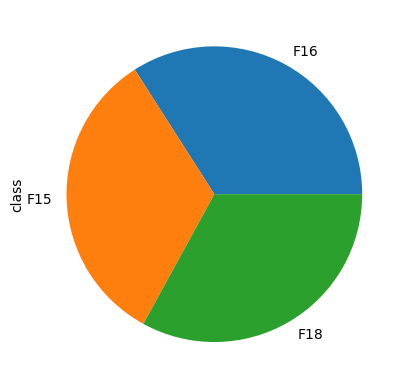

In [12]:
target = ["F16", "F15", "F18"] #Classes we want to keep

df_reduced = df.loc[df["class"].isin(target)].copy(deep=True)

print(f"Reduced from {len(df.index)} rows to {len(df_reduced.index)} rows")
counts = df_reduced["class"].value_counts()
print(counts)
counts.plot(kind="pie")


# Loading images

## Normalize images and bounding boxes

In [13]:
df_norm = df_reduced.copy(deep = True)
# Iteración sobre el dataframe
for index, row in df_norm.iterrows():
    width = row["width"]
    height = row["height"]

    # Calcular las coordenadas normalizadas
    x_min = row['xmin'] / width
    y_min = row['ymin'] / height
    x_max = row['xmax'] / width
    y_max = row['ymax'] / height

    # Obtener la etiqueta de clase
    label = row['class']

    x_center = (x_min + x_max)/2
    y_center = (y_min + y_max)/2

    width = x_max - x_min
    height = y_max - y_min

    # Guardar las coordenadas normalizadas y la etiqueta en el dataframe
    df_norm.at[index, 'x_center'] = x_center
    df_norm.at[index, 'y_center'] = y_center
    df_norm.at[index, 'width'] = width
    df_norm.at[index, 'height'] = height

### Remove columns YOLO does not use

In [14]:
df_norm = df_norm.drop(["xmin", "ymin", "xmax", "ymax"], axis=1)
df_norm.head(1)

,filename,width,height,class,x_center,y_center
12,ad43fb020cfe369d157507dbf42eb570,0.351391,0.152493,F15,0.79063,0.378299


### Change class to numeric value

In [15]:
df_norm = df_norm.replace({"F15": 0, "F16": 1,"F18": 2})
df_norm.sample(5)

,filename,width,height,class,x_center,y_center
7492,8f67b81f85e591db607bd99f2527752a,0.083056,0.070476,0,0.711250,0.582857
8172,0ed1aa8912117fa1a96607f386a1d5df,0.070023,0.074074,2,0.175637,0.407407
14182,a5d1e23068e34c011f84449b83bf0b86,0.149306,0.072840,0,0.085764,0.899383
8876,9ec3e1cb08d68774461223784c153b86,0.069792,0.053207,2,0.554167,0.324708
1544,7e78f33ac70bde4402c7bf790accc68d,0.069397,0.142283,0,0.675647,0.492255


## Train Test Split
In order to balance the classes between train/test we first group them by class and split each class into train and test

In [16]:
#Create Train and Test sets
train_dfs = []
test_dfs = []

grouped = df_norm.groupby('class')

for category, group_df in grouped:
    # Divide the sets
    train_df, test_df = train_test_split(group_df, test_size=0.2, random_state=42) #For each group, we set an 80% train 20%test
    train_dfs.append(train_df)
    test_dfs.append(test_df)

train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)


In [17]:
print("----------- TRAIN -------------")
print("Total: "+ str(len(train_df)))
print(train_df["class"].value_counts())
print("\n----------- TEST -------------")
print("Total: " + str(len(test_df)))
print(test_df["class"].value_counts())


----------- TRAIN -------------
Total: 2605
1    887
0    859
2    859
Name: class, dtype: int64

----------- TEST -------------
Total: 652
1    222
0    215
2    215
Name: class, dtype: int64


# Using YOLO
We will download the YOLOv5 repo in order to change the classes in its model to ours so it can classify them


## Downloading repo and installing dependencies


In [18]:
!git clone https://github.com/ultralytics/yolov5 ../references/yolov5  # clone
%pip install -qr ../references/yolov5/requirements.txt  # install

Cloning into '../references/yolov5'...
remote: Enumerating objects: 16012, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 16012 (delta 0), reused 1 (delta 0), pack-reused 16008
Receiving objects: 100% (16012/16012), 14.52 MiB | 27.64 MiB/s, done.
Resolving deltas: 100% (11012/11012), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


## Copying our .yml config file to yolov5 folder
The file contains the info necessary for the 5 classes we will be using

In [19]:
!cp yolo_files/skydefender.yaml ../references/yolov5/data

### Creating folder structure for yolov5

In [20]:
# yolov5
#   -images
#    |- train
#    |- val
#   -labels
#    |- train
#    |- val
!rm -fr ../data/processed/yolov5

!mkdir -p ../data/processed/yolov5
!mkdir -p ../data/processed/yolov5/images
!mkdir -p ../data/processed/yolov5/labels
!mkdir -p ../data/processed/yolov5/images/train
!mkdir -p ../data/processed/yolov5/images/val
!mkdir -p ../data/processed/yolov5/labels/train
!mkdir -p ../data/processed/yolov5/labels/val


### Copying images to its folder

In [21]:
import shutil

grouped_train = train_df.groupby('filename')
grouped_test = test_df.groupby('filename')

def convert_yolo(group, folder):
    for i, (filename, df) in enumerate(group, 1):
        # Create file in labels
        with open(f"../data/processed/yolov5/labels/{folder}/{i}.txt", "w+") as f:
            for _, row in df.iterrows():
                line = str(
                    f"{row['class']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n")
                f.write(line)
        # Move the image and change its name
        shutil.copy(f"../data/raw/{filename}.jpg",
                    f"../data/processed/yolov5/images/{folder}/{i}.jpg")

convert_yolo(grouped_train, "train")
convert_yolo(grouped_test, "val")


In [22]:
%cd ../references/yolov5
import torch
import utils
display = utils.notebook_init()  # checks
%cd ../../notebooks

YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.1/78.2 GB disk)
/content/sky-defender/notebooks


# Training YOLOv5

We will train our firt model with the following Hyperparameters:
* Epochs: 50
* Image size: 640
* Batch Size: 64
* Optimizer and Learning rate: Default

In [ ]:
!python ../references/yolov5/train.py --weights yolov5s.pt --data skydefender.yaml --epochs 50 --img 640 --cache --batch 64

train: weights=yolov5s.pt, cfg=, data=skydefender.yaml, hyp=../references/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../references/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_

# Evaluating
For the evaluation of our models we will be using 3 things, the charts and the confusion matrix automatically generated by YOLO in the end of the training. And the metrics printed in the end of the training.

The specific metrics we will be looking for comparing models, which are also the ones that YOLO gives by default. This metrics are *precission* and *recall* for evaluating the classification and *mAP50* for evaluating the accuracy of the bounding boxes.

For all models we will be using 50 epoch and a batch size that maximizes the VRAM usage of the GPU.


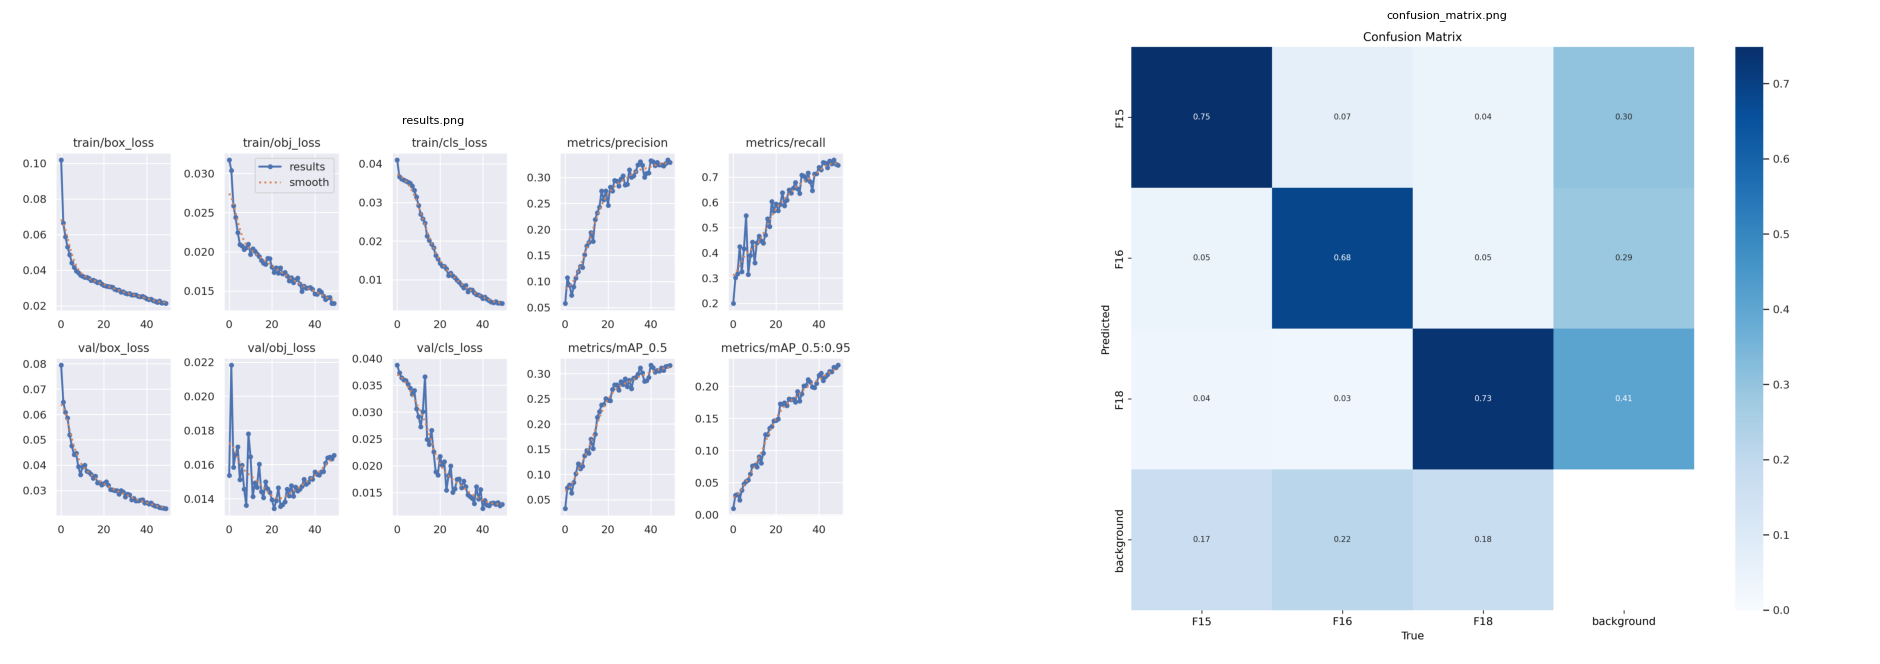

In [ ]:
from random import sample
import matplotlib.image as mpimg

lastest = max(os.listdir("../references/yolov5/runs/train"))

charts = ["results.png", "confusion_matrix.png", "val_batch0_labels.jpg","val_batch0_pred.jpg"]

fig, axs = plt.subplots(1, 2 , figsize=(24,24))
for filename, ax in zip(charts[:2], axs.flatten()):
    img = mpimg.imread(f"../references/yolov5/runs/train/{lastest}/{filename}")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(filename, fontsize=8, pad=2)



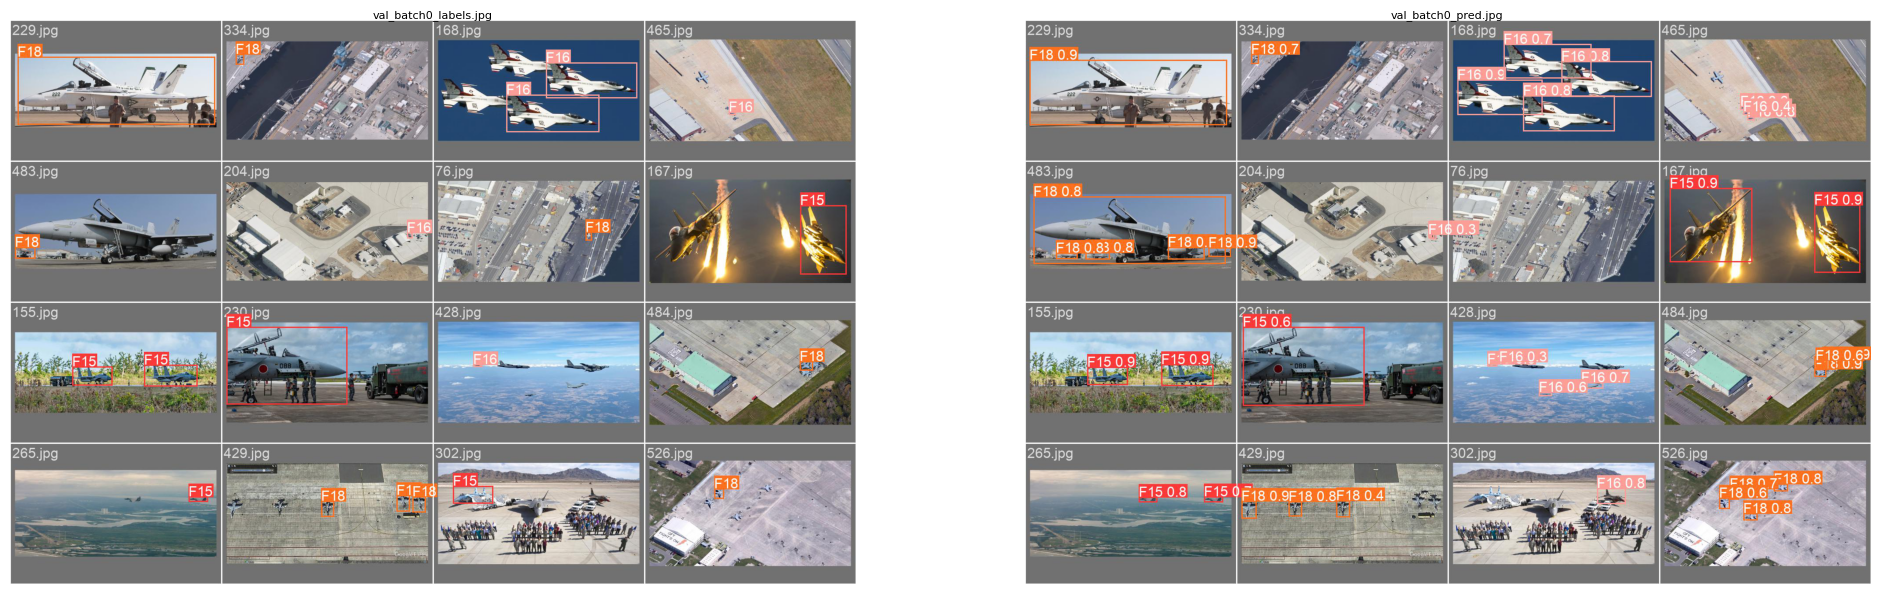

In [ ]:

fig, axs = plt.subplots(1, 2 , figsize=(24,24))
for filename, ax in zip(charts[2:], axs.flatten()):
    img = mpimg.imread(f"../references/yolov5/runs/train/{lastest}/{filename}")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(filename, fontsize=8, pad=2)

# Improving the model

## What hyperparameters can we change?
The hyperparameters that we can change and affect the accuracy of our model are the following:

### Image resolution
Now we're using a resolution of 640x640px, we can increase it in order so the model can learn more complex features from the aircraft but by doing it, we will have to reduce the batch size so the resources don't overflow and the training time might increase.

### Optimizer
By default, as we have read in the YOLOv5 Documentation, it uses the SGD optimizer, but we will try with this other two options:
* adam
* rmsprop

We could also try other hyperparameters like *LearningRate* but as the charts don't look very noisy we will not experiment with it.

## Increasing the resolution
We will increase the resolution to 960, wich is a 50% increase from the original one.

In [ ]:
!python ../references/yolov5/train.py --weights yolov5s.pt --data skydefender.yaml --epochs 50 --img 960 --cache --batch 32

train: weights=yolov5s.pt, cfg=, data=skydefender.yaml, hyp=../references/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=960, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../references/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_

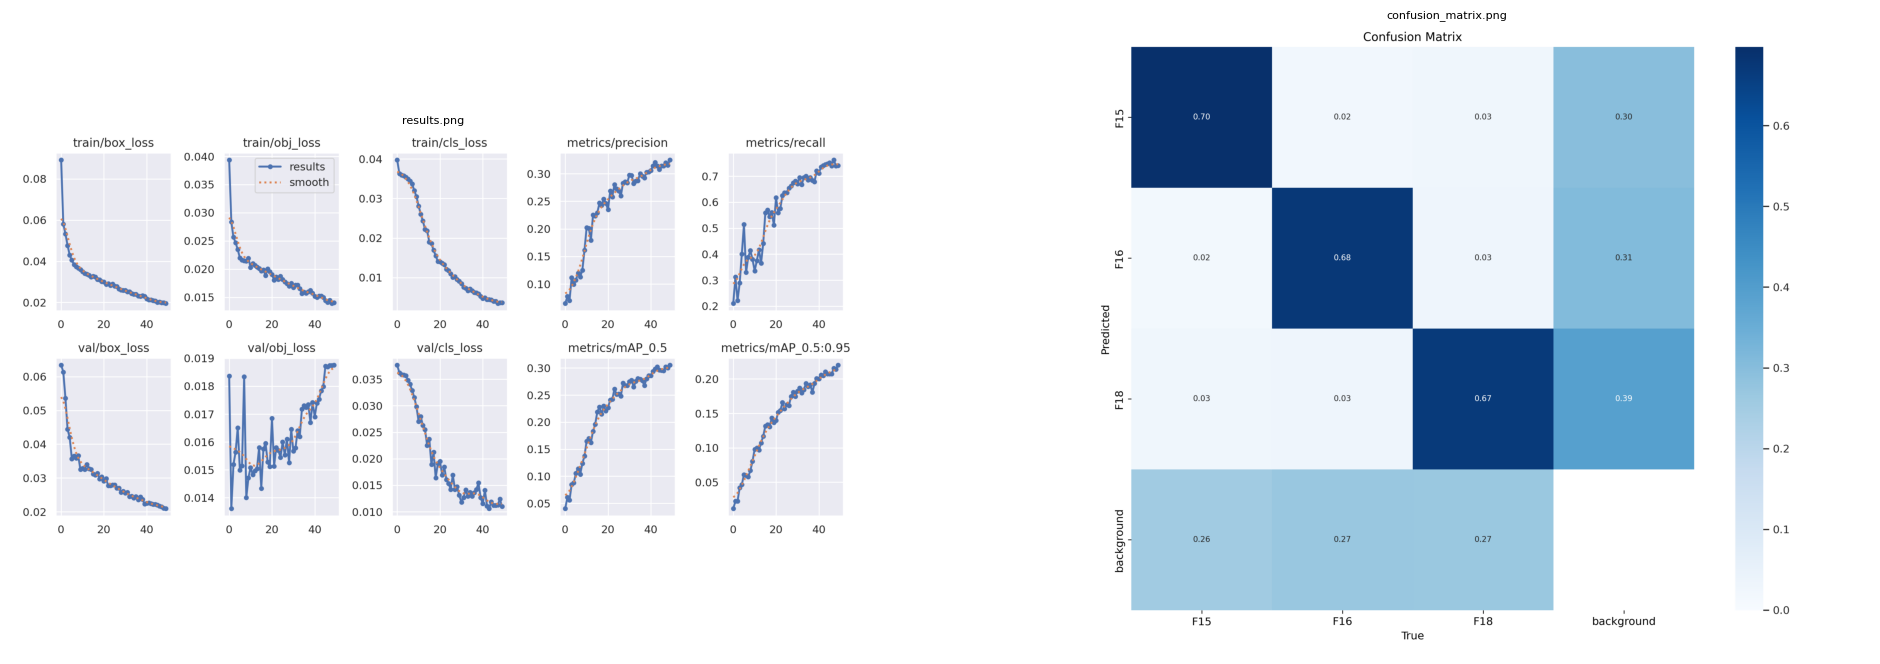

In [ ]:
from random import sample
import matplotlib.image as mpimg

lastest = max(os.listdir("../references/yolov5/runs/train"))

charts = ["results.png", "confusion_matrix.png", "val_batch0_labels.jpg","val_batch0_pred.jpg"]

fig, axs = plt.subplots(1, 2 , figsize=(24,24))
for filename, ax in zip(charts[:2], axs.flatten()):
    img = mpimg.imread(f"../references/yolov5/runs/train/{lastest}/{filename}")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(filename, fontsize=8, pad=2)

### Conclusion


```
Run        Class  P          R          mAP50      mAP50-95:
Original   all    0.329      0.752      0.316      0.233
Increased  all    0.325      0.741      0.305       0.22

```





Increasing the resolution does not increase the accuracy, even makes it worse and makes the training time much longer.

The decrease in the metrics might be caused because the pretrained weights of YOLOv5 are pretrained with 640x640px images.

## Trying other optimizers
### Adam
If we want to use the Adam optimizer, we just have to add the `--optimizer "AdamW"` parameter.

In [ ]:
!python ../references/yolov5/train.py --weights yolov5s.pt --data skydefender.yaml --epochs 50 --img 640 --cache --batch 64 --optimizer 'AdamW'

train: weights=yolov5s.pt, cfg=, data=skydefender.yaml, hyp=../references/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=AdamW, sync_bn=False, workers=8, project=../references/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, f

### Conclusion


```
Run        Class  P          R          mAP50      mAP50-95:
Original   all   0.329      0.752       0.316       0.233
Adam       all   0.209      0.489       0.189       0.131
```

Also, in this case, we can see that the model is unable to learn as good as with the SGD optimizer.


# Trying other Hyperparameters Colections
By default, YOLOv5 uses the scratch-low hyperparameters file, but there is a med and high variations that might improve the accuracy of our model.

## Scratch Medium

In [ ]:
!python ../references/yolov5/train.py --weights yolov5s.pt --data skydefender.yaml --epochs 50 --img 640 --cache --batch 64 --hyp hyp.scratch-med.yaml

train: weights=yolov5s.pt, cfg=, data=skydefender.yaml, hyp=hyp.scratch-med.yaml, epochs=50, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../references/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.

### Conclusion


```
Run           Class  P          R          mAP50      mAP50-95:
Original      all    0.329      0.752      0.316      0.233
Scrach Med    all    0.321      0.697      0.312      0.231
```

In this case, the accuracy seems to be more or less the same. The only change in this configuration from the original is the *mixup* parameter that is setted to 0.1 instead of 0.

What *mixup* does is puting images on top of other images so with the top one semitransparent, we get more objects in one image.

In [23]:
!python ../references/yolov5/train.py --weights yolov5s.pt --data skydefender.yaml --epochs 150 --img 640 --cache --batch 64

train: weights=yolov5s.pt, cfg=, data=skydefender.yaml, hyp=../references/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../references/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl

### Trying more epochs

We tried to do more epochs using the best optimizer in order to see if we could get a better performance in it.
As we've seen those results are a bit better than before.
To mention that those results are by multiplying by 3 the number of epochs we did (and assuming the computational cost of it), the new results even that are better, we think that a much bigger number of epochs aren't recommended due the cost in computation time and such a small amount of improvement.

# Summary Of The Results

In conclusion, after employing various techniques to enhance the performance of our model, we have determined that altering the base model did not yield improved results. The original base model exhibited the highest accuracy when predicting the presence and type of aircraft in our images.

Analysis of the model's metrics reveals the following observations:

- The Confusion Matrix demonstrates strong predictive capabilities, as evidenced by the high accuracy along the diagonal. However, there are slight challenges with background detection, resulting in occasional missed aircraft detections.

- The charts depicting accuracy metrics illustrate the progressive learning of our model, with improved results observed as each epoch advances.

- Our decision to employ 50 epochs appears to be appropriate, as indicated by the stability observed across various metrics at this stage.
